<a href="https://colab.research.google.com/github/xanasa14/MLImplementations/blob/master/ToxicComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import pandas as pd
import numpy as np
import re
import nltk 

import matplotlib.pyplot as plt
#98.08%

In [2]:
#toxic_comments = pd.read_csv("/content/train.csv",engine='python',encoding='utf-8')
toxic_comments = pd.read_csv("/content/drive/MyDrive/toxicCommentz/train.csv")
print(toxic_comments['comment_text'][123])


Should say something about his views as an educationalist and socialist political commentator.

Link to http://www.langandlit.ualberta.ca/Fall2004/SteigelBainbridge.html mentions this a bit - he stood as an election candidate for Respect.


In [3]:
print(toxic_comments['comment_text'].head())
print(toxic_comments.shape)
#to clear out all links from our text
toxic_comments['comment_text'] = toxic_comments['comment_text'].str.replace('(http|https):\/\/www.[A-Za-z0-9.\/?]+\s', '', case=False)
print(toxic_comments['comment_text'][123])


0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object
(159571, 8)
Should say something about his views as an educationalist and socialist political commentator.

Link to mentions this a bit - he stood as an election candidate for Respect.


In [4]:
print(len(toxic_comments['comment_text']))
toxic_comments.dropna(subset=['comment_text'], inplace=True)
print(len(toxic_comments['comment_text']))




toxic_comments.head()


159571
159571


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
counter = 0
offensive = []
nonOffensive = []
for i in range(len(toxic_comments)):
  #if (i <= 500):
  if (int(toxic_comments["toxic"][i]) == 1 or int(toxic_comments["severe_toxic"][i]) == 1 or 
      int(toxic_comments["obscene"][i]) == 1 or int(toxic_comments["threat"][i]) == 1 or
      int(toxic_comments["insult"][i]) == 1 or int(toxic_comments["identity_hate"][i]) == 1):
    offensive.append(1)
    nonOffensive.append(0)
  else: 
    nonOffensive.append(1)
    offensive.append(0)

toxic_comments['offensive'] = offensive
toxic_comments['nonOffensive'] = nonOffensive


#toxic_comments = toxic_comments[toxic_comments.offensive == 1]


In [6]:
print("comment_text:" + str(toxic_comments["comment_text"][96]))
print("comment_text:" + str(toxic_comments["comment_text"][960]))
print("comment_text:" + str(toxic_comments["comment_text"][9600]))
print("comment_text:" + str(toxic_comments["comment_text"][96000]))
print("comment_text:" + str(toxic_comments["comment_text"][77]))
print("comment_text:" + str(toxic_comments["comment_text"][777]))
print("comment_text:" + str(toxic_comments["comment_text"][7777]))
print("comment_text:" + str(toxic_comments["comment_text"][123]))
print("comment_text:" + str(toxic_comments["comment_text"][1234]))
print("comment_text:" + str(toxic_comments["comment_text"][12345]))

print("Toxic:" + str(toxic_comments["toxic"][0]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][0]))
print("Obscene:" + str(toxic_comments["obscene"][0]))
print("Threat:" + str(toxic_comments["threat"][0]))
print("Insult:" + str(toxic_comments["insult"][0]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][0]))


print(len(toxic_comments))
print("Offensive :" + str (toxic_comments['offensive'][0]))
print("Non-offensive :" + str (toxic_comments['nonOffensive'][0]))
print("comment_text:" + str(toxic_comments["comment_text"][123]))


comment_text:"
Hi
Thanks for our kind words. See you around ) Talk "
comment_text:Nevermind. The  has assimilated those puppies. ) Sorry for the bother. Cheese/Wine
comment_text:"

 WP:ABUSE 

Sorry, but all the reports (of which I saw) have been rejected as there was no blocks at all.  This is not AIV (but even then some were not accepted.) ~~123~~ → report "
comment_text:(Back over to the left) Let's do this  let's take a point and talk it over.   Shark, would you start?  Pick a sentence or point that you want to change, that you've had difficulty seeing eye to eye about, and let's discuss it. — \talk
comment_text:In the same direction, is it really necessary to name all the US states who recognize it? Why not give just the number of states? This is not an American encyclopedia, but an universal one, I don't see why every single US states which recognize it should be named.  (ix)
comment_text:"

 Gift cards for downloads 
Re: ""As of December 28, 2007 it is not possible to use gift c

In [7]:
#toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels = toxic_comments[["offensive", "nonOffensive"]]

toxic_comments_OffensiveOrNot = toxic_comments[["comment_text","offensive", "nonOffensive"]]
print(toxic_comments_OffensiveOrNot["offensive"][168])
print(toxic_comments_OffensiveOrNot["comment_text"][168])

1
You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


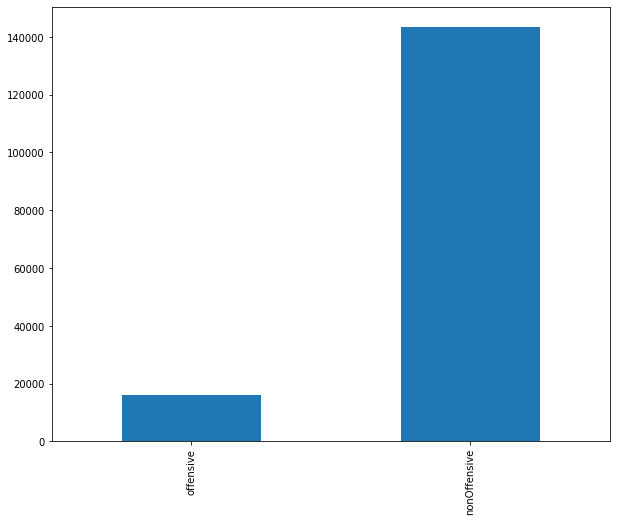

In [8]:

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [9]:
import spacy
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en', disable=['parser', 'ner'])
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
import string  
def loweringText(text):
    text = text.lower()
    return text
#Removing punctuationes and those characters
def remove_punctuations(text):
  for punctuation in string.punctuation:
      text = text.replace(punctuation, ' ')
  return text
# Lowering Text from DataFrame

#Remove stopwords : words that do not put as much significance or impact as other words in the description
def remove_StopWords(text):
  text = str(text)
  line = text.split()
  text = ""
  for word in line:
    if(word not in stop_words):
      text += word
      text += " "
  return text
#Implementing lemmatization words by word
def lemmatize(text):
  line = text.split()
  txt = ""
  for word in line:
    doc = nlp(word)
    for token in doc:
      txt += token.lemma_
      txt += " "
  return txt
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence



def remove_abb(text):
  for line in text:
    #Either use:
    text = text.replace("he's", "he is")
    text = text.replace("there's", "there is")
    text = text.replace("we're", "we are")
    text = text.replace("that's", "that is")
    text = text.replace("won't", "will not")
    text = text.replace("they're", "they are")
    text = text.replace("can't", "cannot")
    text = text.replace("wasn't", "was not")
    text = text.replace("don\x89Ûªt", "do not")
    text = text.replace("aren't", "are not")
    text = text.replace("isn't", "is not")
    text = text.replace("what's", "what is")
    text = text.replace("haven't", "have not")
    text = text.replace("hasn't", "has not")
    text = text.replace("there's", "there is")
    text = text.replace("it's", "it is")
    text = text.replace("you're", "you are")
    text = text.replace("i'm", "i am")
    text = text.replace("shouldn't", "should not")
    text = text.replace("wouldn't", "would not")
    text = text.replace("I\x89Ûªm", "i am")
    text = text.replace("here's", "here is")
    text = text.replace("you've", "you have")
    text = text.replace("you\x89Ûªve", "you have")
    text = text.replace("couldn't", "could not")
    text = text.replace("we've", "we have")
    text = text.replace("it\x89Ûªs", "it is")
    text = text.replace("doesn\x89Ûªt", "does not")
    text = text.replace("it\x89Ûªs", "it is")
    text = text.replace("here\x89Ûªs", "here is")
    text = text.replace(".jpeg", " ")
    text = text.replace(".jpg", " ")
    text = text.replace(".png", " ")
    text = text.replace("'s", " ")
    text = text.replace("→", " ")  
    text = text.replace("\n", " ")
    text = text.replace("trácht", " ")
    text = text.replace("piece", " ")
    text = text.replace("didn't", "did not")
    text = text.replace("who's", "who is")
    text = text.replace("i\x89Ûªve", "i have")
    text = text.replace("y'all", "you all")
    text = text.replace("can\x89Ûªt", "cannot")
    text = text.replace("would've", "would have")
    text = text.replace("it'll", "it will")
    text = text.replace("we'll", "we will")
    text = text.replace("wouldn\x89Ûªt", "would not")
    text = text.replace("we've", "we have")
    text = text.replace("he'll", "he will")
    text = text.replace("weren't", "were not")
    text = text.replace("they'll", "they will")
    text = text.replace("they'd", "they would")
    text = text.replace("that\x89Ûªs", "that is")
    text = text.replace("they've", "they have")
    text = text.replace("i'd", "i would")
    text = text.replace("donå«t", "do not")
    text = text.replace("should've", "should have")
    text = text.replace("you\x89Ûªre", "you are")
    text = text.replace("where's", "where is")
    text = text.replace("don\x89Ûªt", "do not")
    text = text.replace("we'd", "we would")
    text = text.replace("i'll", "i will")
    text = text.replace("weren't", "were not")
    text = text.replace("can\x89Ûªt", "cannot")
    text = text.replace("you\x89Ûªll", "you will")
    text = text.replace("I\x89Ûªd", "i would")
    text = text.replace("let's", "let us")
    text = text.replace("it's", "it is")
    text = text.replace("don't", "do not")
    text = text.replace("you're", "you are")
    text = text.replace("i've", "i have")
    text = text.replace("ain't", "am not")
    text = text.replace("doesn't", "does not")
    text = text.replace("i'd", "i would")
    text = text.replace("didn't", "did not")
    text = text.replace("you'll", "you will")
    text = text.replace("let's", "let us")
    text = text.replace("youve", "you have")
    text = text.replace("could've", "could have")
    text = text.replace("haven't", "have not")
    text = text.replace("you'd", "you would")
    text = text.replace("it's", "it is")
    text = text.replace(" like ", " ")
    text = text.replace(" wikipedia ", " ")
    text = text.replace("article ", " ")
    text = text.replace("articles ", " ")
    text = text.replace("know ", " ")
    text = text.replace("want ", " ")
    text = text.replace("page ", " ")
    text = text.replace("wiki ", " ")
    text = text.replace("im ", " ")
    text = text.replace("still ", " ")
    text = text.replace("hi ", " ")
    text = text.replace(" talk ", " ")
    text = text.replace(" hey ", " ")
    text = text.replace(" would ", " ")
    text = text.replace(" uhm ", " ")
    text = text.replace(" mp ", " ")
    text = text.replace(" edits ", " ")
    text = text.replace(" edit ", " ")
    text = text.replace(" editing ", " ")
    text = text.replace(" edited ", " ")
    text = text.replace(" br ", " ")
    text = text.replace(" div ", " ")
    text = text.replace("admin ", " ")
    text = text.replace(" text ", " ")
    text = text.replace(" tag ", " ")
    text = text.replace(" file ", " ") 
    text = text.replace(" a ", " ")
    text = text.replace(" b ", " ")
    text = text.replace(" c ", " ")
    text = text.replace(" d ", " ")
    text = text.replace(" e ", " ")
    text = text.replace(" f ", " ")
    text = text.replace(" g ", " ")
    text = text.replace(" h ", " ")
    text = text.replace(" i ", " ")
    text = text.replace(" j ", " ")
    text = text.replace(" k ", " ")
    text = text.replace(" l ", " ")
    text = text.replace(" m ", " ")
    text = text.replace(" n ", " ")
    text = text.replace(" o ", " ")
    text = text.replace(" p ", " ")
    text = text.replace(" q ", " ")
    text = text.replace(" r ", " ")
    text = text.replace(" s ", " ")
    text = text.replace(" t ", " ")
    text = text.replace(" u ", " ")
    text = text.replace(" v ", " ")
    text = text.replace(" w ", " ")
    text = text.replace(" x ", " ")
    text = text.replace(" y ", " ")
    text = text.replace(" z ", " ")
    text = text.replace(" wp ", " ")
    text = text.replace("@ ", " ")
    text = text.replace("   ", " ")
    text = text.replace("  ", " ")    
    return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
#toxic_comments["comment_text_X"] = toxic_comments['comment_text'].apply(remove_punctuations).apply(loweringText).apply(remove_StopWords).apply(lemmatize)
#FIRST LOWER CASE EVERYTHING 
toxic_comments["comment_text"] = toxic_comments['comment_text'].apply(loweringText)
print("Lowering the Text ")
#Second formalize to normal English words
toxic_comments["comment_text"] = toxic_comments['comment_text'].apply(remove_abb)
print("removed remove_abb ")
#Accepting only letters
#remove any other character that are not letters
toxic_comments["comment_text"] = toxic_comments['comment_text'].apply(preprocess_text)
print(" preprocess_text ")



Lowering the Text 
removed remove_abb 
 preprocess_text 


In [11]:
#Removing any punctuations left
toxic_comments["comment_text"] = toxic_comments['comment_text'].apply(remove_punctuations)
print("removed puctuation from the Text ")

removed puctuation from the Text 


In [12]:
#remove any meaningless word
toxic_comments["comment_text"] = toxic_comments['comment_text'].apply(remove_StopWords)
print("removed remove_StopWords ")

removed remove_StopWords 


In [13]:
#Clean Empty ones 
print(len(toxic_comments['comment_text']))
toxic_comments.dropna(subset=['comment_text'], inplace=True)
print(len(toxic_comments['comment_text']))



#TAKES TOO MUCH TIME DUE TO THE HUGE DATASET
#toxic_comments["comment_text"] = toxic_comments['comment_text'].apply(lemmatize)
#print("removed lemmatize ")

159571
159571


In [14]:
print(len(toxic_comments["comment_text"]))
print(len(toxic_comments["offensive"]))




159571
159571


In [15]:
z = []
#toxic_comments_labels = toxic_comments[["offensive"]]


y = toxic_comments_labels.values
X = toxic_comments["comment_text"]
print(len(y))
print(len(X))

159571
159571


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42, stratify=y)

In [17]:
y_train

array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/gloves/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(2, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14313900  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 14,431,406
Trainable params: 117,506
Non-trainable params: 14,313,900
_________________________________________________________________
None


In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=49, verbose=1, validation_split=0.3)

Epoch 1/49
655/655 [==============================] - 17s 22ms/step - loss: 0.3437 - accuracy: 0.9023 - val_loss: 0.2649 - val_accuracy: 0.8977
Epoch 2/49
655/655 [==============================] - 14s 21ms/step - loss: 0.3142 - accuracy: 0.8981 - val_loss: 0.3288 - val_accuracy: 0.8984
Epoch 3/49
655/655 [==============================] - 14s 21ms/step - loss: 0.3283 - accuracy: 0.8985 - val_loss: 0.3271 - val_accuracy: 0.8987
Epoch 4/49
655/655 [==============================] - 14s 21ms/step - loss: 0.3161 - accuracy: 0.8968 - val_loss: 0.1848 - val_accuracy: 0.9366
Epoch 5/49
655/655 [==============================] - 14s 21ms/step - loss: 0.1940 - accuracy: 0.9319 - val_loss: 0.1575 - val_accuracy: 0.9453
Epoch 6/49
655/655 [==============================] - 14s 21ms/step - loss: 0.1500 - accuracy: 0.9485 - val_loss: 0.1457 - val_accuracy: 0.9495
Epoch 7/49
655/655 [==============================] - 14s 21ms/step - loss: 0.1731 - accuracy: 0.9427 - val_loss: 0.1634 - val_accuracy:

In [23]:

text_model = history
score = history.model.evaluate(X_test, y_test, verbose=1, batch_size=128)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

312/312 [==============================] - 3s 9ms/step - loss: 0.2572 - accuracy: 0.9474
Test Score: 0.25719016790390015
Test Accuracy: 0.9474343657493591


In [24]:

print(X_test.shape)
print(y_test.shape)

print(score)
toxic_comments_labels.values



(39893, 200)
(39893, 2)
[0.25719016790390015, 0.9474343657493591]


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [25]:
model.save('/content/drive/MyDrive/toxicCommentz/my_model.h5')
# LOAD 
#import keras
#model = keras.models.load_model('/content/drive/MyDrive/toxicCommentz/my_model.h5')



In [26]:
y_pred = model.predict(X_test)
print(y_pred)
print(y_test)
print(y_pred.shape)
print(y_test.shape)

[[7.6533249e-04 9.9926203e-01]
 [3.0188810e-04 9.9972278e-01]
 [6.9566369e-02 9.2378438e-01]
 ...
 [5.6415133e-02 9.3837965e-01]
 [4.6708123e-03 9.9507266e-01]
 [3.0186080e-04 9.9972278e-01]]
[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]
(39893, 2)
(39893, 2)


In [27]:
toxic_comments.iloc[24579]["comment_text"]


'certainly somwhat surprising nutty assertion jerusalem post failed reliable source part conrad black zionist media conspiracy think fact anyone see right http en wikipedia org wiki talk muhammad al durrah npov light karsenty verdict guess rule '

In [28]:
print(y_pred[0])
print(y_pred[1])

print(y_test[0])
print(y_test[1])
print(y_test[2])
print(y_test[3])
print(y_test[4])
print(y_test[13])
print(y_test[14])

ListaOfAnswers = y_test.tolist()



print(np.argmax(y_pred[0]) ,ListaOfAnswers[0][0])
print(np.argmax(y_pred[1]) ,ListaOfAnswers[0][1])

for i in range(2):
  print(np.argmax(y_pred[i]) ,ListaOfAnswers[i],y_pred[0])


[7.6533249e-04 9.9926203e-01]
[3.018881e-04 9.997228e-01]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
1 0
1 1
1 [0, 1] [7.6533249e-04 9.9926203e-01]
1 [0, 1] [7.6533249e-04 9.9926203e-01]


In [29]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
target_names= ["Offensive" , "NonOffensive"]
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), target_names=target_names))
#print(classification_report(np.argmax(y_pred, axis=1), y_test, target_names=target_names))
matrix = metrics.confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1),)
#matrix = metrics.confusion_matrix(y_pred.argmax(axis=1), y_test)

              precision    recall  f1-score   support

   Offensive       0.72      0.75      0.73      3851
NonOffensive       0.97      0.97      0.97     36042

    accuracy                           0.95     39893
   macro avg       0.84      0.86      0.85     39893
weighted avg       0.95      0.95      0.95     39893



In [30]:
matrix

array([[ 2905,   946],
       [ 1151, 34891]])

In [31]:
print(y_pred.shape)
y_pred2 = y_pred
y_test2 = y_test
Size = len (y_test2)
y_test2 = y_test2.reshape((Size,-1))
y_pred2 = y_pred2.reshape((Size,-1))
print(y_pred2.shape)
print(y_test2.shape)
matrix = metrics.confusion_matrix(y_pred2.argmax(axis=1), y_test2.argmax(axis=1))

(39893, 2)
(39893, 2)
(39893, 2)


In [32]:
matrix

array([[ 2905,   946],
       [ 1151, 34891]])

In [33]:
CR = metrics.accuracy_score(y_pred2.argmax(axis=1), y_test2.argmax(axis=1))
print(CR)

0.9474343869851853


In [34]:
print(toxic_comments['comment_text'][159541])

absurd absurd great white shark total vandalism sexual fucking bullshit spam useful encyclopedia stop bullshit admins everywhere choice stop bullshit else blocked permanently user factual man 


In [35]:
predictionx = model.predict(X_test[2])
print(predictionx[0])
#wrong_predictionsx = X_test[predictionx != y_test]

[0.4045486  0.60486495]


In [36]:
print(X_test[2])

predictionX = np.argmax(model.predict(X_test[0]))
print(predictionX)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3


In [37]:
toxic_comments.head(45)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,offensive,nonOffensive
0,0000997932d777bf,explanation made username hardcore metallica f...,0,0,0,0,0,0,0,1
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man really trying war guy constantly remov...,0,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,cannot make real suggestions improvement wonde...,0,0,0,0,0,0,0,1
4,0001d958c54c6e35,sir hero chance remember,0,0,0,0,0,0,0,1
5,00025465d4725e87,congratulations well use tools well,0,0,0,0,0,0,0,1
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,1,0
7,00031b1e95af7921,vandalism matt shirvington reverted please ban...,0,0,0,0,0,0,0,1
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,0,1
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,0,1


In [38]:
test10 = "gift cards downloads december possible use gift cards purchase mp even though gift card faq claims yes amazon com gift cards used buy amazon mp unbox downloads strictly speaking false statement able pay orders gift card time one person already removed line reverted good way go providing verification "
#PREDICTING ONE 

test11 = "still"


lista = [test11]


lista = tokenizer.texts_to_sequences(lista)
lista = pad_sequences(lista, padding='post', maxlen=maxlen)
tst = model.predict(np.array( lista ))

pred_name = np.argmax(tst)
print(pred_name)
#tst
if(pred_name == 1):
  print("it is Non-offensive")

elif(pred_name ==0 ):
  print("it is Offensive")



1
it is Non-offensive


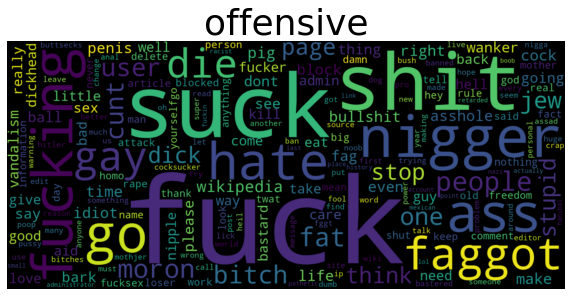

In [39]:
#WordCloud Visualizations
#Method for creating wordclouds
from wordcloud import WordCloud,STOPWORDS

from PIL import Image
def display_cloud(data,label):
    plt.subplots(figsize=(10,10))
    text = toxic_comments[toxic_comments[label]==1]["comment_text"].tolist()
    wc = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1800,
                          height=800,
                         )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(label,fontsize=36)
    plt.show()
    
display_cloud(toxic_comments,"offensive")

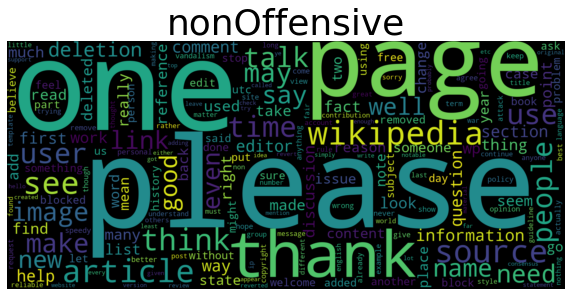

In [40]:
#WordCloud Visualizations
#Method for creating wordclouds
from wordcloud import WordCloud,STOPWORDS

from PIL import Image
def display_cloud(data,label):
    plt.subplots(figsize=(10,10))
    text = toxic_comments[toxic_comments[label]==1]["comment_text"].tolist()
    wc = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1800,
                          height=800,
                         )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(label,fontsize=36)
    plt.show()
    
display_cloud(toxic_comments,"nonOffensive")

In [41]:
from collections import Counter
text = toxic_comments[toxic_comments["offensive"]==1]["comment_text"].tolist()
print(type(text))


<class 'list'>


In [42]:
from collections import Counter
print(type(text))

print("Offensive words ")
Counter(" ".join(toxic_comments[toxic_comments["offensive"]==1]["comment_text"]).split()).most_common(100)


<class 'list'>
Offensive words 


[('fuck', 10004),
 ('shit', 3694),
 ('fucking', 3337),
 ('nigger', 3306),
 ('suck', 3274),
 ('ass', 3005),
 ('go', 2965),
 ('hate', 2656),
 ('get', 2446),
 ('gay', 2267),
 ('die', 2141),
 ('people', 2070),
 ('faggot', 2028),
 ('fat', 1982),
 ('moron', 1891),
 ('bitch', 1841),
 ('one', 1707),
 ('cunt', 1574),
 ('user', 1554),
 ('stop', 1512),
 ('stupid', 1488),
 ('wikipedia', 1483),
 ('sucks', 1447),
 ('think', 1397),
 ('jew', 1364),
 ('pig', 1359),
 ('dick', 1337),
 ('penis', 1245),
 ('time', 1187),
 ('bullshit', 1164),
 ('life', 1162),
 ('block', 1153),
 ('even', 1140),
 ('right', 1111),
 ('dont', 1079),
 ('asshole', 1070),
 ('make', 1060),
 ('please', 1043),
 ('page', 1041),
 ('see', 1040),
 ('wanker', 1037),
 ('fag', 1028),
 ('going', 1014),
 ('balls', 1005),
 ('bark', 1001),
 ('vandalism', 996),
 ('idiot', 988),
 ('cannot', 972),
 ('sex', 958),
 ('cock', 951),
 ('little', 914),
 ('really', 903),
 ('good', 867),
 ('bad', 847),
 ('also', 833),
 ('nipple', 826),
 ('hell', 825),
 ('wel

In [43]:
from collections import Counter
print(type(text))

print("Non-Offensive words ")
Counter(" ".join(toxic_comments[toxic_comments["nonOffensive"]==1]["comment_text"]).split()).most_common(50)


<class 'list'>
Non-Offensive words 


[('please', 28759),
 ('one', 27493),
 ('wikipedia', 22403),
 ('see', 20544),
 ('also', 19810),
 ('think', 18687),
 ('page', 16465),
 ('article', 16442),
 ('people', 16426),
 ('use', 16196),
 ('talk', 15973),
 ('may', 15277),
 ('time', 14711),
 ('thanks', 13469),
 ('user', 13463),
 ('even', 12330),
 ('could', 12327),
 ('good', 11957),
 ('make', 11945),
 ('well', 11625),
 ('information', 11604),
 ('deletion', 11393),
 ('sources', 11113),
 ('get', 10977),
 ('image', 10840),
 ('name', 10718),
 ('way', 10516),
 ('first', 10502),
 ('help', 10475),
 ('new', 10283),
 ('pages', 10243),
 ('source', 10145),
 ('section', 9972),
 ('thank', 9720),
 ('need', 9503),
 ('wp', 9378),
 ('say', 9307),
 ('made', 9184),
 ('many', 9077),
 ('used', 8943),
 ('discussion', 8930),
 ('much', 8911),
 ('deleted', 8797),
 ('find', 8599),
 ('work', 8314),
 ('really', 8308),
 ('point', 8291),
 ('since', 8271),
 ('add', 8185),
 ('read', 7782)]